## MNIST に関するスパース信号再現

DU-ISTA法によるスパース信号再現

Copyright (c) 2022 Tadashi Wadayama  
Released under the MIT license  
https://opensource.org/licenses/mit-license.php

In [16]:
using LinearAlgebra
using Flux
using MLDatasets
using Plots
gr()
using Flux.Data: DataLoader
using Flux: onehotbatch
using Tullio

### グローバル変数の設定

In [17]:
K = 50

n = 784
m = 512
num_itr = 25
adam_lr = 5e-5
max_inner = 50

A = randn(m, n)
γ_opt = 1.0/maximum(eigvals(A'*A)) 

0.00039770443174880676

### MNIST画像を表示 (ミニバッチの先頭16個を表示)

In [18]:
function show_img(x)
    x = reshape(x, 28, 28, K)
    p = []
    for k in 1:16
        tmp = x[:,:,k]
        @tullio img[i,j] := tmp[j,28-i+1]
        append!(p,[heatmap(img, c=:bone, legend=false, xticks=false, yticks=false)])
    end
    plot(p[1],p[2],p[3],p[4],p[5],p[6],p[7],
        p[8],p[9],p[10],p[11],p[12],p[13],p[14],p[15],p[16],layout=(4,4))
end

show_img (generic function with 1 method)

### データローダを準備

In [19]:
xtrain, _ = MLDatasets.MNIST.traindata(Float32)
xtest, _ = MLDatasets.MNIST.testdata(Float32)
train_loader = DataLoader(xtrain, batchsize=K, shuffle=true)
test_loader = DataLoader(xtest, batchsize=K);

### ミニバッチ生成関数

In [20]:
function mini_batch(K)
    x_org,_ = iterate(train_loader)
    x = reshape(x_org, 784, K)
    y = A*x
    return x,y
end    

function test_mini_batch(K)
    x_org,_ = iterate(test_loader)
    x = reshape(x_org, 784, K)
    y = A*x
    return x,y
end    

test_mini_batch (generic function with 1 method)

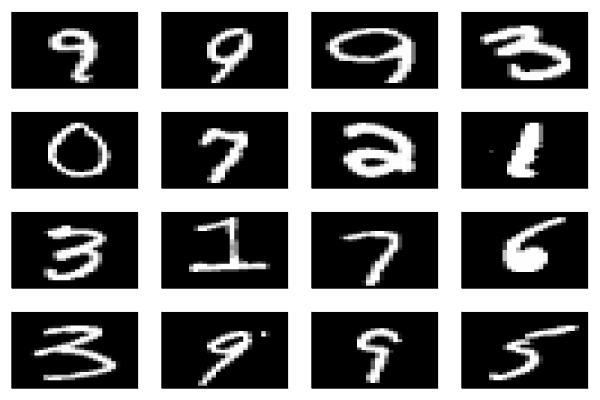

In [21]:
x,_ = mini_batch(K)
show_img(x)

### ISTAによる再現実験

In [22]:
function ISTA(max_itr, y)
    x = zeros(n, K)
    for i in 1:max_itr
        x = x - γ_opt*A'*(A*x - y)
        x = softshrink.(x, γ_opt)
    end
    return x
end

ISTA (generic function with 1 method)

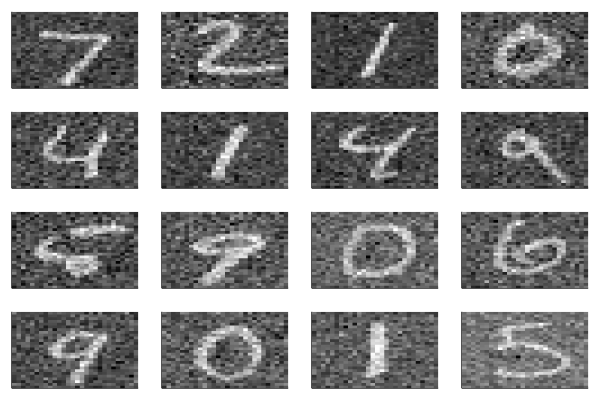

In [23]:
x_test, y_test = test_mini_batch(K)
x_hat = ISTA(num_itr, y_test);
p1 = show_img(x_hat)

### DU-ISTA法の反復

In [24]:
function DU_ISTA(max_itr, y, γ, α)
    x = zeros(n, K)
    for i in 1:max_itr
        x = x - γ[i]*A'*(A*x - y)
        x = softshrink.(x, α[i])
    end
    return x
end

DU_ISTA (generic function with 1 method)

In [25]:
function loss(x, y)
    return norm(x - y)^2/K
end  

loss (generic function with 1 method)

### 学習プロセス

In [26]:
function train(opt, γ, α)
    ps = Flux.params(γ, α) 
    for itr in 1:num_itr 
        for i in 1:max_inner 
            x,y = mini_batch(K)
            gs = gradient(ps) do
                x_hat = DU_ISTA(itr, y, γ, α)
                loss(x, x_hat)
            end
            Flux.Optimise.update!(opt, ps, gs) 
        end
        x, y = test_mini_batch(K)
        x_hat = DU_ISTA(itr, y, γ, α)
        println(itr, " ", loss(x, x_hat))
    end
end

train (generic function with 1 method)

In [27]:
γ_train = γ_opt*ones(num_itr)
α_train = γ_opt*ones(num_itr)
opt = ADAM(adam_lr)
train(opt, γ_train, α_train)

1 45.00779438778996
2 34.985115775660404
3 30.152652120865188
4 27.37075675373348
5 24.712542093191782
6 22.041347315214242
7 19.894813676770877
8 18.044527147340983
9 16.294648813785077
10 14.671987856073162
11 13.156392124656973
12 11.754944098638132
13 10.458180992059582
14 9.197226852357414
15 8.042603721949668
16 7.121112757959375
17 6.176170007148796
18 5.451116878372792
19 4.8874053947980896
20 4.323019706028878
21 3.8064277504060993
22 3.3840803085907254
23 3.0457271718681405
24 2.748746504820708
25 2.485084163138898


### DU-ISTAによる再現実験

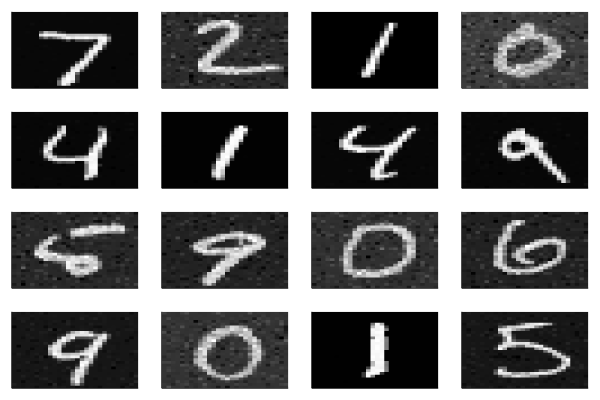

In [28]:
x_hat = DU_ISTA(num_itr, y_test, γ_train, α_train);
p2 = show_img(x_hat)

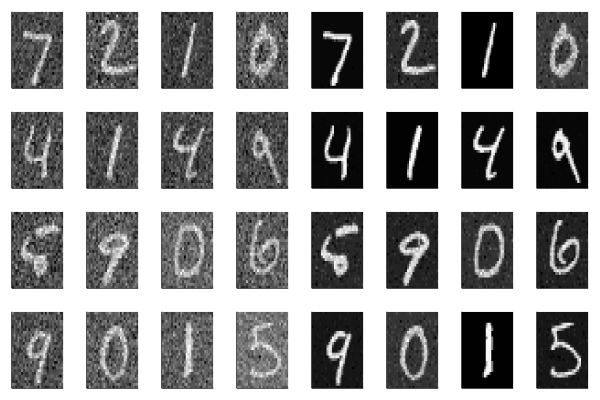

In [29]:
plot(p1,p2)

In [30]:
savefig("MNIST-reconstruction.pdf")